
# Exercice : Contamination dans un lac

Nous allons étendre l'exercice de contamination d'une rivière de 1D à 2D. On suppose la fuite continue (constante dans le temps) d'un contaminant dans un lac qui est animé d'un courant en $x$ et $y$ (Figure ci-dessous). La source de contamination est un périmètre circulaire centré en $x_{src} = L_x/4$ et $y_{src} = L_y/4$ de rayon $r_C = 1.5$ m. Pour cela, vous pouvez utiliser la fonction `np.meshgrid`.

Le polluant se décompose avec une constante de décroissance de $\gamma = 0.001$. Les équations à résoudre sont presque les mêmes que pour l'exercice précédent, à l'exception du terme du taux de dégradation (ou de réaction) :

$$\frac{\partial C}{\partial t} = -\frac{\partial q_x}{\partial x} -\frac{\partial q_y}{\partial y} - V_x \frac{\partial C}{\partial x} - V_y \frac{\partial C}{\partial y}\ -\gamma C,\: $$

$$q_x = - D \frac{\partial C}{\partial x} \: ; \: \: q_y = - D \frac{\partial C}{\partial y}$$

où $C$ est la concentration du contaminant, $D$ est la diffusivité, et $V_x$ et $V_y$ sont les vitesses horizontales de l'eau. Nous supposons que la concentration sur les bords du domaine est nulle en tout temps. 
 
![](./fig/ex_2.png)

*Figure: Let but de l'exercise est de modéliser l'évolution d'un contaminant dans un lac (ici Q=2).*

Nous voulons écrire un code avec deux variantes. Définissez un paramètre Q, qui vaut 1 ou 2, et utilisez des clauses conditionnelles pour écrire un unique code générique qui fonctionne pour les deux variantes.

- Q1: Réalisez une première simulation avec une vitesse uniforme sur tout le domaine.
- Q2: Ensuite, changez le signe de la vitesse `V_x` dans la partie supérieure du modèle ($y > L_y/2$).



| **Paramètres:**                               | **Valeurs:**              |
|-----------------------------------------------|---------------------------|
| Concentration du polluant "Cmax"             | 20                        |
| Longueur $x$ du modèle $L_x$                 | 50 m                      |
| Longueur $y$ du modèle $L_y$                 | 50 m                      |
| Centre de la fuite $x$                       | $L_x/4$ m                 |
| Centre de la fuite $y$                       | $L_y/4$ m                 |
| Rayon de la fuite $r_C$                      | 1.5 m                     |
| Nombre de cellules "nx"                       | 110                       |
| Nombre de cellules "ny"                       | 120                       |
| Temps total                                   | 500 s                     |
| Diffusivité du polluant                       | 0.02 m²/s                 |
| Constante de décroissance $\gamma$           | 0.001  $s^{-1}$      |
| **Q=1**                                       |                           |
| Vitesse x du lac $V_x$                       | 0.1 m/s                   |
| Vitesse y du lac $V_y$                       | 0.2 m/s                   |
| **Q=2**                                      |                           |
| $V_x$ dans la moitié inférieure               | 0.1 m/s                   |
| $V_x$ dans la moitié supérieure               | -0.1 m/s                  |
| Vitesse y du lac $V_y$                       | 0.2 m/s                   |

*Table 1: Paramètres pour le problème du lac.*

### ✅ **À vous de faire !** 

## Imports nécessaires

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

---
## Définition de la classe Parameters

In [ ]:
class Parameters:
    pass

---
## Étape 1 : Définition des paramètres

Commençons par créer une fonction qui définit tous les paramètres du problème de manière organisée.

In [ ]:
def define_parameters(Q=1):
    p = Parameters()
    
    p.D = 0.02          
    p.Lx = 50.0         
    p.Ly = 50.0         
    p.Vx0 = 0.1         
    p.Vy0 = 0.2         
    p.Cmax = 20.0       
    p.gamma = 1e-3      
    p.ttot = 500.0      
    p.xsrc = p.Lx / 4  
    p.ysrc = p.Ly / 4  
    p.r_c = 1.5         
    
    p.ny = 110          
    p.nx = 120          
    p.dx = p.Lx / (p.nx - 1)  
    p.dy = p.Ly / (p.ny - 1)  
    p.nout = 250        
    p.Q = Q             
    
    p.x = np.linspace(0, p.Lx, p.nx)
    p.y = np.linspace(0, p.Ly, p.ny)
    p.X, p.Y = np.meshgrid(p.x, p.y)
    
    return p

### ✅ Test de la fonction `define_parameters`

In [ ]:
params = define_parameters(Q=1)
print(f"Grille: {params.nx}×{params.ny}, dx={params.dx:.3f}m, dy={params.dy:.3f}m")
print(f"Source: ({params.xsrc}, {params.ysrc})m, rayon={params.r_c}m")
print(f"✓ Paramètres définis correctement")

---
## Étape 2 : Initialisation de la solution

Créons une fonction pour initialiser le champ de concentration.

In [ ]:
def initial_solution(p):
    return np.zeros((p.ny, p.nx))

### ✅ Test de la fonction `initial_solution`

In [ ]:
C = initial_solution(params)
print(f"Forme: {C.shape}, somme: {C.sum()} (devrait être 0)")
print(f"✓ Initialisation correcte")

---
## Étape 3 : Initialisation du courant

Créons une fonction pour initialiser les champs de vitesse.

In [95]:
def initial_current(p):
    Vx = p.Vx0 * np.ones((p.ny, p.nx - 1))
    Vy = p.Vy0 * np.ones((p.ny - 1, p.nx))
    
    if p.Q == 2:
        Vx[int(p.ny / 2):, :] = -p.Vx0
    
    return Vx, Vy

### ✅ Test de la fonction `initial_current`

In [ ]:
# Test pour Q=1 et Q=2
for Q in [1, 2]:
    params_test = define_parameters(Q=Q)
    Vx, Vy = initial_current(params_test)
    print(f"Q={Q}: Vx ∈ [{Vx.min():.2f}, {Vx.max():.2f}], Vy ∈ [{Vy.min():.2f}, {Vy.max():.2f}]")
print(f"✓ Vitesses initialisées correctement")

---
## Étape 4 : Mise à jour de la source

Créons une fonction pour appliquer la source de contamination.

In [96]:
def update_source(C, p):
    rad = np.sqrt((p.X - p.xsrc)**2 + (p.Y - p.ysrc)**2)
    C[rad < p.r_c] = p.Cmax

### ✅ Test de la fonction `update_source`

In [ ]:
C = initial_solution(params)
update_source(C, params)
print(f"Nb cellules avec C=Cmax: {np.sum(C == params.Cmax)}")
print(f"✓ Source appliquée correctement")

---
## Étape 5 : Diffusion

Créons une fonction pour calculer le terme de diffusion.

In [97]:
def update_diffusion(C, p, dt):
    qy = -p.D * (C[1:, 1:-1] - C[:-1, 1:-1]) / p.dy
    qx = -p.D * (C[1:-1, 1:] - C[1:-1, :-1]) / p.dx
    dCdtd = -((qx[:, 1:] - qx[:, :-1]) / p.dx + (qy[1:, :] - qy[:-1, :]) / p.dy)
    C[1:-1, 1:-1] += dt * dCdtd

### ✅ Test de la fonction `update_diffusion`

In [ ]:
params_test = define_parameters(Q=1)
C_test = initial_solution(params_test)
update_source(C_test, params_test)

dt = min(params_test.dx, params_test.dy)**2 / (4.1 * params_test.D)
for i in range(50):
    update_diffusion(C_test, params_test, dt)

print(f"Après 50 pas: C_max={C_test.max():.2f}, C_mean={C_test.mean():.4f}")
print(f"✓ La diffusion étale le contaminant")

---
## Étape 6 : Advection

Créons une fonction pour calculer le terme d'advection (transport par le courant).

In [98]:
def update_advection(C, Vx, Vy, p, dt):
    dCdta = np.zeros((p.ny, p.nx))
    
    dCdta[:, 1:]  -= (Vx > 0) * Vx * (C[:, 1:] - C[:, :-1]) / p.dx
    dCdta[:, :-1] -= (Vx < 0) * Vx * (C[:, 1:] - C[:, :-1]) / p.dx
    
    dCdta[1:, :]  -= (Vy > 0) * Vy * (C[1:, :] - C[:-1, :]) / p.dy
    dCdta[:-1, :] -= (Vy < 0) * Vy * (C[1:, :] - C[:-1, :]) / p.dy
    
    C += dt * dCdta

### ✅ Test de la fonction `update_advection`

In [ ]:
params_test = define_parameters(Q=1)
C_test = initial_solution(params_test)
update_source(C_test, params_test)
Vx, Vy = initial_current(params_test)

dt = 0.1 * min(params_test.dx/np.max(np.abs(Vx)), params_test.dy/np.max(np.abs(Vy)))
for i in range(100):
    update_advection(C_test, Vx, Vy, params_test, dt)

print(f"Après 100 pas: C_max={C_test.max():.2f}, C_mean={C_test.mean():.4f}")
print(f"✓ Le contaminant est transporté par le courant")

---
## Étape 7 : Réaction (décroissance)

Créons une fonction pour le terme de réaction (dégradation du contaminant).

In [ ]:
def update_reaction(C, p, dt):
    C += dt * (-C * p.gamma)

### ✅ Test de la fonction `update_reaction`

In [ ]:
params_test = define_parameters(Q=1)
C0 = 10.0
C_test = np.ones((params_test.ny, params_test.nx)) * C0
dt = 1.0

for i in range(1000):
    update_reaction(C_test, params_test, dt)

C_theory = C0 * np.exp(-params_test.gamma * 1000)
erreur = abs(C_test.mean() - C_theory) / C_theory * 100
print(f"Après 1000s: C_numérique={C_test.mean():.4f}, C_théorique={C_theory:.4f}")
print(f"Erreur relative: {erreur:.2f}%")
print(f"✓ Décroissance exponentielle correcte")

---
## Étape 8 : Conditions aux limites

Créons une fonction pour appliquer les conditions aux limites.

In [ ]:
def apply_bc(C):
    C[0, :] = 0
    C[-1, :] = 0
    C[:, 0] = 0
    C[:, -1] = 0

### ✅ Test de la fonction `apply_bc`

In [ ]:
params_test = define_parameters(Q=1)
C_test = np.ones((params_test.ny, params_test.nx)) * 5.0
apply_bc(C_test)

somme_bords = C_test[0,:].sum() + C_test[-1,:].sum() + C_test[:,0].sum() + C_test[:,-1].sum()
print(f"Somme des bords: {somme_bords} (devrait être 0)")
print(f"✓ Conditions aux limites correctes (C=0 sur les bords)")

---
## Étape 9 : Fonction de visualisation

Créons une fonction pour afficher les résultats.

In [ ]:
def plot_solution(C, p, time, fig, ax, first_call=False):
    clear_output(wait=True)
    ax.clear()
    ax.imshow(C, extent=[0, p.Ly, 0, p.Lx], origin='lower', cmap='Blues', vmin=0, vmax=20)
    ax.set_xlabel('Distance y (m)')
    ax.set_ylabel('Distance x (m)')
    ax.set_title(f'Concentration à t = {int(time)} s')
    if first_call:
        plt.colorbar(ax.images[0], ax=ax, label='Concentration')
    display(fig)
    print(f"Progression : {time/p.ttot*100:.1f}% (t = {int(time)} s)")

---
## Étape 10 : Assemblage final - Code complet

Maintenant que toutes les fonctions sont testées, assemblons-les dans un code compact qui résout le problème complet.

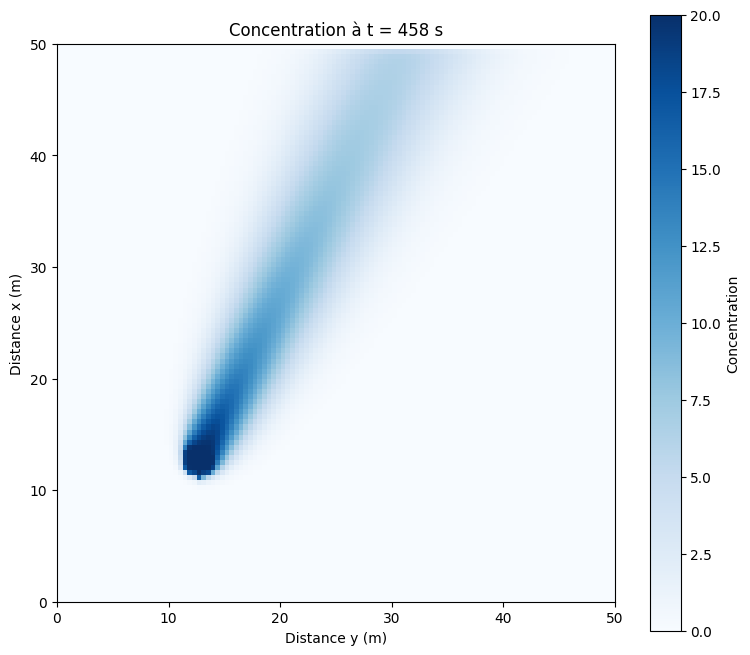

Progression : 91.8% (t = 458 s)

SIMULATION TERMINÉE!


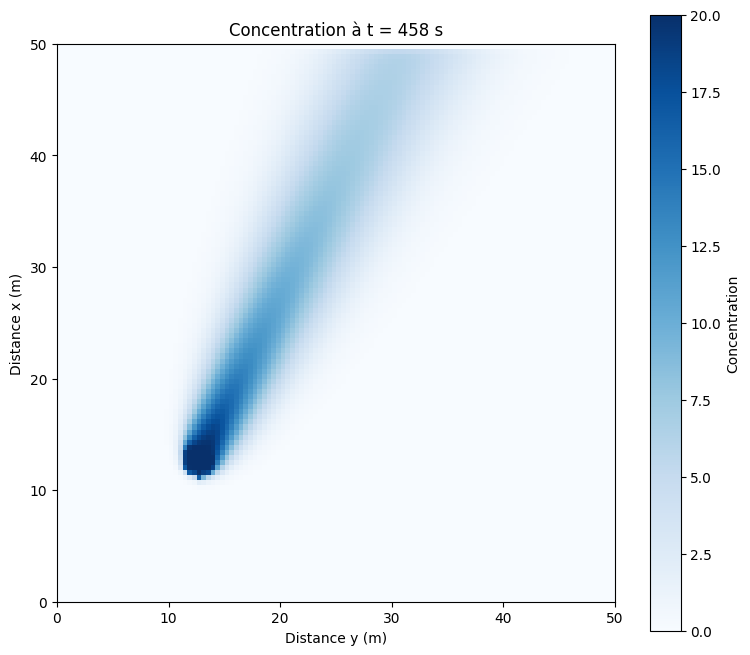

In [99]:
# ========================================
# SIMULATION COMPLÈTE
# ========================================

Q = 1

p = define_parameters(Q=Q)
C = initial_solution(p)
Vx, Vy = initial_current(p)

dt = min(min(p.dx, p.dy)**2 / (4.1 * p.D), 
         0.1 * min(p.dx / np.max(np.abs(Vx)), p.dy / np.max(np.abs(Vy))))
nt = int(p.ttot / dt)

print("=" * 60)
print(f"SIMULATION DE CONTAMINATION D'UN LAC (Q={Q})")
print("=" * 60)
print(f"Grille : {p.nx} x {p.ny} cellules")
print(f"Pas de temps : {dt:.4f} s")
print(f"Nombre de pas de temps : {nt}")
print(f"Temps total : {p.ttot} s")
print("=" * 60)

fig, ax = plt.subplots(figsize=(9, 8))
time = 0.0

for it in range(nt):
    time += dt
    
    update_source(C, p)
    update_diffusion(C, p, dt)
    update_advection(C, Vx, Vy, p, dt)
    update_reaction(C, p, dt)
    apply_bc(C)
    
    if it % p.nout == 0:
        plot_solution(C, p, time, fig, ax, first_call=(it==0))

print("\n" + "=" * 60)
print("SIMULATION TERMINÉE!")
print("=" * 60)